# 4.
CountVectorizer e TF-IDF


In [ ]:
!pip install -q transformers sentence-transformers scikit-learn tensorflow


In [ ]:
import pandas as pd, numpy as np, re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt

df = pd.read_csv('/content/dataset.csv')
df = df[['Comment','sentiment']].dropna().rename(columns={'Comment':'text','sentiment':'label'})

def preprocess(text):
    text = str(text).replace('\n',' ')
    text = re.sub(r'http\S+',' ', text)
    text = re.sub(r'\[.*?\]\(.*?\)',' ', text)
    text = re.sub(r'[^A-Za-z0-9\s]',' ', text)
    return text.lower()

df['text_pp'] = df['text'].apply(preprocess)
df.head()


,text,label,text_pp
0,Them: I don't think I like this game.\n\nMe: B...,negative,them i don t think i like this game me but...
1,Then you leave them to farm the smaller creatu...,negative,then you leave them to farm the smaller creatu...
2,Nothing beats the feeling you get when you see...,positive,nothing beats the feeling you get when you see...
3,"[Also, they're made of paper](https://i.imgur....",negative,also they re made of paper edit i tried...
4,Haha... That was exactly it when my brother tr...,positive,haha that was exactly it when my brother tr...


## count/TF-IDF + classificadores

In [ ]:
X = df['text_pp'].values
y = df['label'].values
le = LabelEncoder(); y_enc = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.30, random_state=42, stratify=y_enc)

vectorizers = {
    'count': CountVectorizer(max_features=5000, ngram_range=(1,2)),
    'tfidf': TfidfVectorizer(max_features=5000, ngram_range=(1,2))
}
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(max_iter=5000)
}

results = {}
for vname, vec in vectorizers.items():
    Xtr = vec.fit_transform(X_train)
    Xte = vec.transform(X_test)
    for cname, clf in classifiers.items():
        clf.fit(Xtr, y_train)
        preds = clf.predict(Xte)
        acc = accuracy_score(y_test, preds)
        prec_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, preds, average='macro')
        results[f"{vname}+{cname}"] = {
            'accuracy': acc, 'f1_macro': f1_macro,
            'report': classification_report(y_test, preds, target_names=le.classes_),
            'cm': confusion_matrix(y_test, preds)
        }

for k,v in results.items():
    print("===",k,"===")
    print("accuracy:",v['accuracy'],"f1_macro:",v['f1_macro'])
    print(v['report'])
    print("Confusion matrix:\n",v['cm'])


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== count+LogisticRegression ===
accuracy: 0.7638349863446888 f1_macro: 0.7228237841794289
              precision    recall  f1-score   support

    negative       0.67      0.50      0.57      1222
     neutral       0.73      0.83      0.78      2725
    positive       0.82      0.81      0.82      3010

    accuracy                           0.76      6957
   macro avg       0.74      0.71      0.72      6957
weighted avg       0.76      0.76      0.76      6957

Confusion matrix:
 [[ 609  390  223]
 [ 156 2271  298]
 [ 143  433 2434]]
=== count+MultinomialNB ===
accuracy: 0.6497053327583728 f1_macro: 0.6202577251232073
              precision    recall  f1-score   support

    negative       0.55      0.48      0.51      1222
     neutral       0.67      0.62      0.64      2725
    positive       0.66      0.75      0.70      3010

    accuracy                           0.65      6957
   macro avg       0.63      0.62      0.62      6957
weighted avg       0.65      0.65      0.6

a)

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-distilroberta-v1')

embeddings = model.encode(df['text_pp'].tolist(), show_progress_bar=True, batch_size=64)

X_train, X_test, y_train, y_test = train_test_split(embeddings, y_enc, test_size=0.30, random_state=42, stratify=y_enc)

classifiers_bert = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'GaussianNB': GaussianNB(),
    'LinearSVC': LinearSVC(max_iter=5000)
}

for cname, clf in classifiers_bert.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, preds, average='macro')
    print("=== DistilBERT +", cname, "===")
    print("accuracy:",acc,"f1_macro:",f1_macro)
    print(classification_report(y_test, preds, target_names=le.classes_))
    print("Confusion:\n", confusion_matrix(y_test, preds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/363 [00:00<?, ?it/s]

=== DistilBERT + LogisticRegression ===
accuracy: 0.6959896507115135 f1_macro: 0.6481309901221649
              precision    recall  f1-score   support

    negative       0.59      0.40      0.48      1222
     neutral       0.71      0.74      0.73      2725
    positive       0.71      0.78      0.74      3010

    accuracy                           0.70      6957
   macro avg       0.67      0.64      0.65      6957
weighted avg       0.69      0.70      0.69      6957

Confusion:
 [[ 490  296  436]
 [ 176 2010  539]
 [ 162  506 2342]]
=== DistilBERT + GaussianNB ===
accuracy: 0.5703607876958459 f1_macro: 0.5503486750490545
              precision    recall  f1-score   support

    negative       0.37      0.54      0.44      1222
     neutral       0.62      0.63      0.63      2725
    positive       0.66      0.53      0.59      3010

    accuracy                           0.57      6957
   macro avg       0.55      0.57      0.55      6957
weighted avg       0.59      0.57     

## b)



In [ ]:
!pip install -q tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 200
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_pp'].tolist())
seqs = tokenizer.texts_to_sequences(df['text_pp'].tolist())
X_pad = pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')
y_cat = keras.utils.to_categorical(y_enc)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.30, random_state=42, stratify=y_enc)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim)])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

embed_dim = 64
num_heads = 2
ff_dim = 64

inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(y_cat.shape[1], activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 64)           1292800   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 200, 64)           41792     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0   

[0.634801983833313, 0.7882708311080933]

## c)

Comparando os resultados, é notável que os métodos de countvectorizer e TF-IDF + classificadores já alcançam um desempenho bem sólido, com uma acurácia próxima de 77% e f1 macro em torno de 0,72 e 0,73. Entre eles, o tf-idf junto da regressão logística ou ao svm linear apresentou melhor equilíbrio entre precisão e recall, mostrando ser mais adequada que o naive bayes. Indicando que mesmo representações mais simples, isso quando associadas a bons classificadores lineares, capturam padrões relevantes do texto e constituem um baseline de fácil implementação.

Já de um outro lado, a expectativa é que a abordagem com distilbert e a arquitetura transformer em Keras tragam ganhos em termos de capacidade de generalização. Nisso, enqunato o transformeer do pdf permite testar arquiteturas mais flexíveis e sob medida para o conjunto de dados, o distilbert se beneficia do pré-treinamento em larga escala, isso normalmente superando os modelos clássicos em métricas como f1 macro. Assim, a comparação sugere que os modelos tradicionais são eficientes e rápidos, mas as arquiteturas baseadas em transformers devem ser mais escolhidas quando se procura uma maior robustez e desempenho em probelmas de classificação de textos com nuances semânticas.

# 2-

In [5]:
!curl -fsSL https://ollama.com/install.sh | sh
print("ollama instalado")
print("\n" + "="*50 + "\n")

import os
import subprocess

command = "nohup ollama serve > ollama.log 2>&1 &"
subprocess.Popen(command, shell=True)
print("tentnado inicializar o ollama")
!sleep 10

print("\n" + "="*50)
print("verificando status do servidore")

print("\n-últimas 10 linhas do log do servidor:")
!tail -n 10 ollama.log

print("\nverificando se o processo está ativo:")
ps_output = !ps -ef | grep ollama | grep -v grep
if len(ps_output) > 0:
    print("Servidor ollama parece estar rodando em segundo plano")
    print(ps_output[0])
else:
    print("servidor ollama deu pau. Reinicialize o ambiente 💔")

print("\n" + "="*50 + "\n")

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
ollama instalado


tentnado inicializar o ollama

verificando status do servidore

-últimas 10 linhas do log do servidor:
Error: listen tcp 127.0.0.1:11434: bind: address already in use

verificando se o processo está ativo:
Servidor ollama parece estar rodando em segundo plano
root        3235       1  0 14:37 ?        00:00:00 ollama serve




In [6]:
print("baixando modelo llama3.1:8b... Pode demorar essa brincadeira")
!ollama pull llama3.1:8b
print("Modelo baixado com sucesso")

baixando modelo llama3.1:8b... Pode demorar essa brincadeira

Modelo baixado com sucesso


✅ conexão com o servidor Ollama deu certo

  dataset.csv carregado com sucesso.

 processamento de 500 comentários iniciado


Extraindo Entidades: 100%|██████████| 500/500 [05:21<00:00,  1.56it/s]



 Total de entidades extraídas: 502
amostra de entidades encontradas: ['diablo', 'FF14', 'YouTube', 'ESO', 'Nenhum resultado encontrado', 'OOT', 'Nintendo', 'League', 'I always end up looking like a clown when I’m focused on beefing up certain stats', 'Gotta']

 gerando histograma


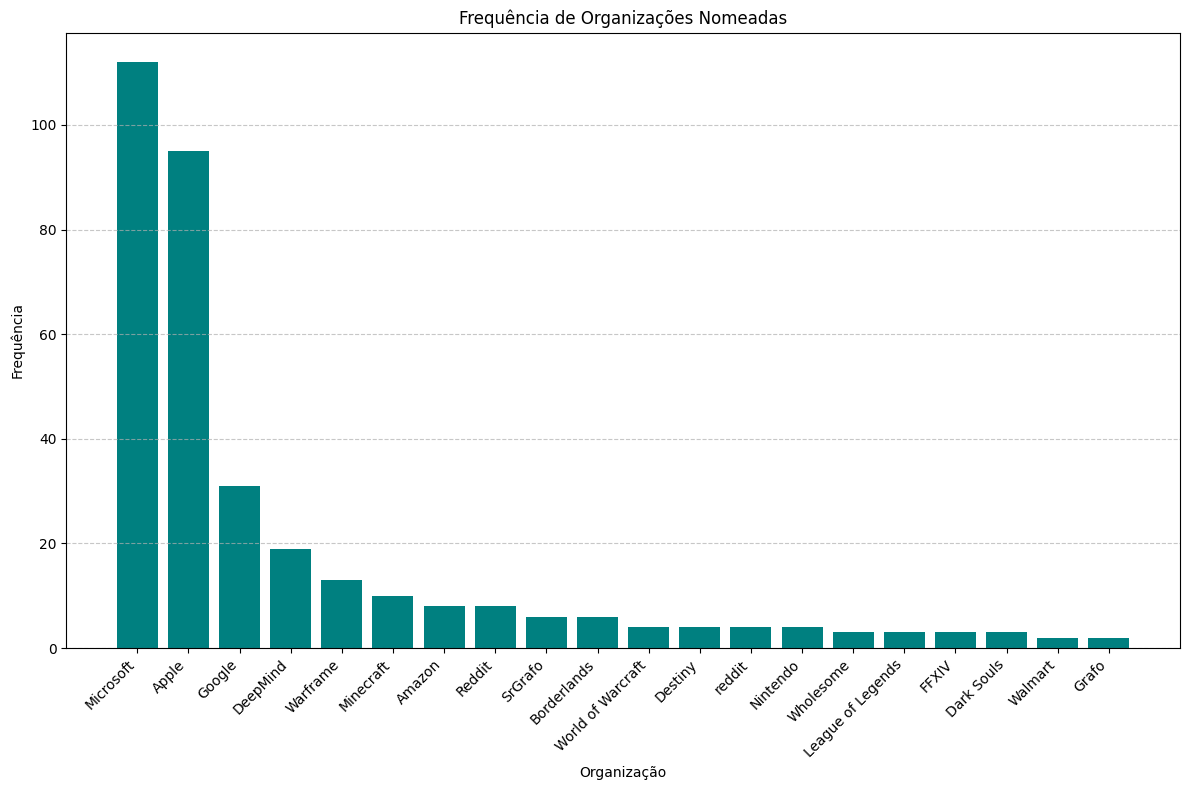

In [8]:
!pip install -q ollama pandas matplotlib tqdm

import ollama
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
import re
from tqdm import tqdm
import io
from google.colab import files

try:
    ollama.list()
    print("✅ conexão com o servidor Ollama deu certo")
except Exception as e:
    print("nao deu pra conhectar ao seridor ollama ")
    print("reinicie o ambiente de execução, e recomeçe a partir da 1ª célula")
    raise e

filename = 'dataset.csv'
try:
    df = pd.read_csv(filename)
    print(f"\n  {filename} carregado com sucesso.")
except FileNotFoundError:
    print(f"\n  {filename} não foi encontrado no ambiente do Colab")
    print("tenha certeza de que o dataset.csv foi enviado direitinho")
    raise

def extract_organizations_ollama(text):
    prompt = f"""
Você é um especialista em extração de entidades. Sua tarefa é identificar apenas as entidades do tipo 'ORGANIZAÇÃO' no texto fornecido.
Responda SOMENTE com uma lista Python de strings, sem nenhuma explicação adicional.
---
Exemplo 1:
Texto: "A Apple anunciou uma parceria com a Microsoft para integrar novas funcionalidades."
ORGANIZAÇÕES: ["Apple", "Microsoft"]
---
Exemplo 2:
Texto: "O CEO do Google, Sundar Pichai, falou sobre os avanços da DeepMind."
ORGANIZAÇÕES: ["Google", "DeepMind"]
---
Texto: "{text}"
ORGANIZAÇÕES:
"""
    try:
        response = ollama.generate(model='llama3.1:8b', prompt=prompt)
        response_text = response['response'].strip()

        match = re.search(r'\[.*?\]', response_text)
        if match:
            list_str = match.group(0)
            entities = ast.literal_eval(list_str)
            if isinstance(entities, list):
                return [ent for ent in entities if ent]
        return []
    except Exception as e:
        return []

all_organizations = []
if "Comment" in df.columns:
    comments_to_process = df["Comment"].dropna().head(500)
    print(f"\n processamento de {len(comments_to_process)} comentários iniciado")
else:
    print("\n colunaComment não foi encontrada no dataset: Encerrando o processamento")
    comments_to_process = []


for comment in tqdm(comments_to_process, desc="Extraindo Entidades"):
    if isinstance(comment, str):
        ents = extract_organizations_ollama(comment)
        all_organizations.extend(ents)

print(f"\n Total de entidades extraídas: {len(all_organizations)}")
if all_organizations:
    print(f"amostra de entidades encontradas: {list(set(all_organizations))[:10]}")

if not all_organizations:
    print("\n nenhuma entidade tipo 'ORGANIZAÇÃO' foi encontrada na amostra processada para gerar um histograma")
else:
    print("\n gerando histograma")
    counter = Counter(all_organizations)
    most_common_entities = counter.most_common(20)
    entities, frequencies = zip(*most_common_entities)

    plt.figure(figsize=(12, 8))
    plt.bar(entities, frequencies, color='teal')
    plt.xticks(rotation=45, ha="right")
    plt.title("Frequência de Organizações Nomeadas")
    plt.xlabel("Organização")
    plt.ylabel("Frequência")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 3-

In [ ]:
!pip install -U transformers
!pip install transformers datasets torch
import os
os.environ["WANDB_DISABLED"] = "true"


  Using cached transformers-4.57.0-py3-none-any.whl.metadata (41 kB)
Using cached transformers-4.57.0-py3-none-any.whl (12.0 MB)
  Using cached transformers-4.57.0-py3-none-any.whl.metadata (41 kB)
Using cached transformers-4.57.0-py3-none-any.whl (12.0 MB)


In [ ]:
# !pip install -q transformers datasets accelerate torch

import torch
import inspect
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

dataset = load_dataset("imdb", split="train")
dataset = dataset.remove_columns([col for col in dataset.column_names if col != "text"])


model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

small_dataset = tokenized_dataset.shuffle(seed=42).select(range(2000))

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(
    output_dir="./results_en",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs_en",
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# treinando o modelo
trainer.train()
trainer.save_model("./results_en/fine_tuned_gpt2_en")

prompt = "Today I felt"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

print("\n=== Generated Texts ===\n")
for i in range(5):
    outputs = model.generate(
        **inputs,
        max_length=80,
        do_sample=True,
        top_k=40,
        top_p=0.92,
        temperature=0.8,
        num_return_sequences=1,
    )
    print(f"Text {i+1}:")
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("-------------------------------------------------\n")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/tmp/ipython-input-2463818182.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Step,Training Loss
500,3.796200
1000,3.377300
1500,3.167800



=== Generated Texts ===

Text 1:
Today I felt that the film was a disappointment. I have to say that there is a lot of good things about this film, but it has to be a little bit of a disappointment for the audience.<br /><br />I feel like the movie is very short on details and it has to be done well with the budget. There is a lot of action but it's not the best part
-------------------------------------------------

Text 2:
Today I felt the love and admiration for the movie, but I didn't like it quite as much. I loved the plot and its art direction. It's not that the movie was good, it's just that the film was the only one I could find. I really felt like I was being watched by a lot of people. I was amazed at how many people I saw it with and how
-------------------------------------------------

Text 3:
Today I felt like I was in a movie that I really liked. The movie has an old classic that I enjoyed. This movie is about the last time that I had the opportunity to see it. I didn't